In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

songs = pd.read_csv('data/songs.csv')

## Wordclouds

Worclouds are a visually appealing way to show the frequency of words. They were created for both Spanish and English songs in the dataset. The results show that Sin Bandera lyrics have prevalence of words like 'siento', 'amor', 'quizás' and 'vida', which is in line with their romantic tendency of song writing.

On the other hand, Loveless has prevalence of 'know', 'never', 'cause' and 'middle night', because of it repetitive verse structure.

In [7]:
# Separate Spanish and English lyrics
sp = songs.loc[songs['language'] == 'Spanish', 'clean_lyrics']
en = songs.loc[songs['language'] == 'English', 'clean_lyrics']

print(sp.shape, type(sp))
print(en.shape, type(en))

(10,) <class 'pandas.core.series.Series'>
(10,) <class 'pandas.core.series.Series'>


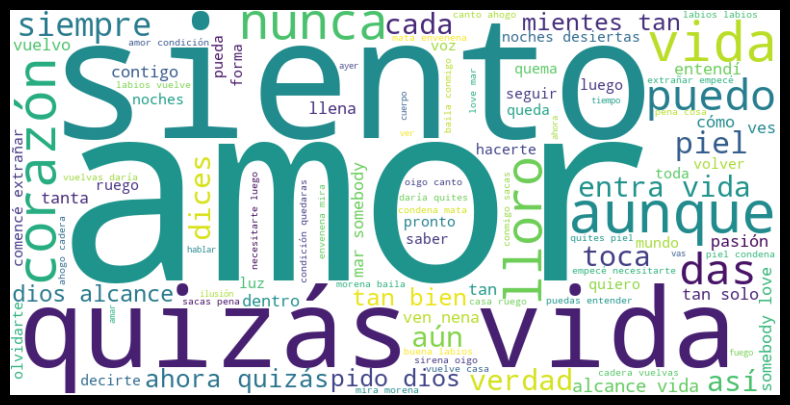

In [8]:
from wordcloud import WordCloud

# Generate wordcloud: Spanish
wordcloud_sp = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(' '.join(sp))

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_sp, interpolation='bilinear')
plt.axis('off')
plt.show()

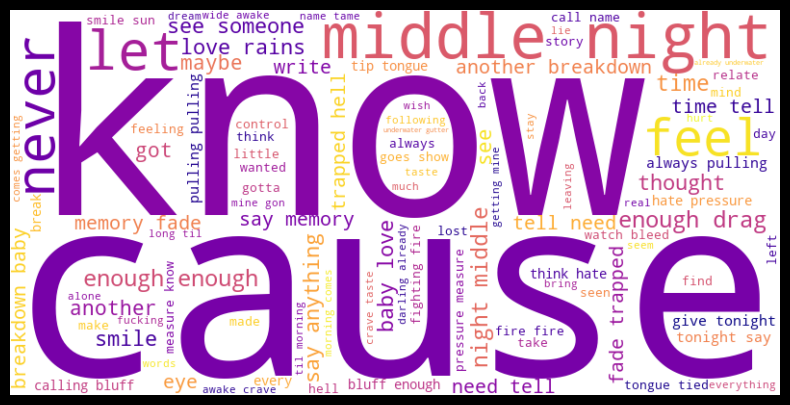

In [9]:
# Generate word cloud: English
wordcloud_en = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    colormap='plasma',
    max_words=100
).generate(' '.join(en))

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_en, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word frequency

A different way to show the frequencies leverages barplots and its quantitative aspect. Making use of the previous lyrics subsets, the `Counter` object from `collections` allows the extraction of the frequencies that were plot later, with a focus on the 10 most common.

The top songs for Sin Bandera reveal more about the word frequencies. 'Vida' is the widely present, like 'amor' and 'quizás' and, although the word size in the wordcloud doesn't resemble exactly the frequencies seen here, is aligned the results previously showed. One interesting thing is the wide presence of the word 'tan', used in Spanish to emphasize adjectives or expressions. Sin Bandera appeals to the intensity of emotions through their songs and lyrics.

Loveless lyrics also have a similar pattern where wordclouds don't completely catch the frequence with size. The top word is 'like', which can represent ressemblance or the fact of liking something. Other common words are 'night', 'know' and 'enough', that come from repetitive-verse songs like 'Middle of the Night'.

It's also possible to see a difference is the distribution of frequent lyrics between the two artists. While Loveless has a maximum frequence of 27 repetitions and a minimum of 15, Sin Bandera has a maximum of 40 and a minimum of 12, meaning that Loveless lyrics have a more uniform structure, expected for a repetitive structure. Other evidence to support this is the existence of simultaneous expressions, showed as bars with the same amount. Loveless exhibits that 'tell', 'cause' and 'middle', and 'could' and 'see' have the same frequence, while Sin Bandera only exhibits one, being this 'piel' and 'aunque'. 

In [10]:
from collections import Counter

# Get word frequencies and count
words_sp = ' '.join(sp).split()
words_en = ' '.join(en).split()

count_sp = Counter(words_sp).most_common(10)
count_en = Counter(words_en).most_common(10)

In [11]:
# The dark theme might be causing the plots to have a black background, so this fixes it
plt.style.use('default')

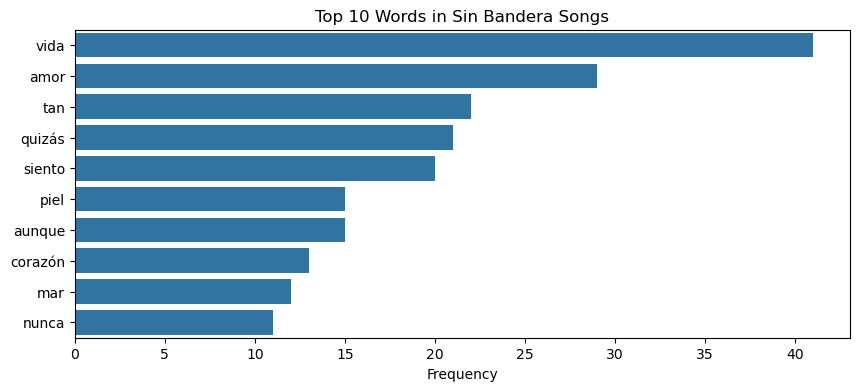

In [12]:
# Create the barplot: Spanish
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    x=[count for _, count in count_sp],
    y=[word for word, _ in count_sp],
    ax=ax
)

ax.set_title('Top 10 Words in Sin Bandera Songs')
ax.set_xlabel('Frequency')
plt.show()

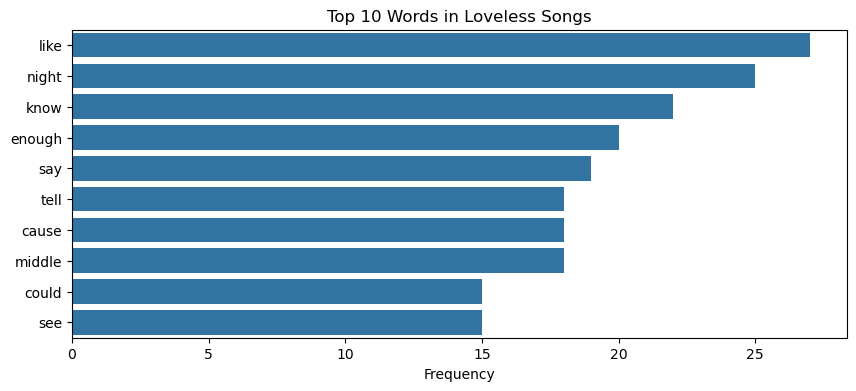

In [13]:
# Create the barplot: English
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(
    x=[count for _, count in count_en],
    y=[word for word, _ in count_en],
    ax=ax
)

ax.set_title('Top 10 Words in Loveless Songs')
ax.set_xlabel('Frequency')
plt.show()

## Emotional labeling

The aim here was to get labels that generally describe an emotion for each song. `SentimentIntensityAnalyzer` from `nltk` was used to permorm the task. It returns a dictionary of four scores, categorized in negative, neutral, positive and compound. 
The approach here consisted in processig each word, taking account for the polarity scores and assigning emotions based on customized thresholds and labels.

The labels to be assigned are 'joy', 'anger', 'sadness', 'neutral'. The focus is on 'anger' and 'sadness', because they are related to the same negative score. I was suggested to include specific and usual anger words to deal with that problem. 

The majority of Spanish songs were labeled as 'neutral', while the majority of English ones were labeled as 'joy'.

In [17]:
# Empty dataframe to store the results
df = pd.DataFrame()

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def get_emotion(text, language):
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    words = text.split()
    
    # Anger indicators
    anger_words = {
        'English': ['no', 'never', 'hate', 'stop'],
        'Spanish': ['no', 'nunca', 'odio', 'basta']
    }
    
    emotions = {
        'joy': scores['pos'] > 0.5,
        # True if at least one word in the lyric matches the anger list
        # Any(): True if at least one item is True
        'anger': (scores['neg'] > 0.5) and any(w in anger_words[language] for w in words),
        # If none anger word is in words and the score condition is met, this returns True 
        'sadness': (scores['neg'] > 0.5) and not any(w in anger_words[language] for w in words),
        'neutral': scores['neu'] > 0.7
    }
    
    return max(emotions, key=emotions.get) # Get the key of the first True encountered

# Add to DataFrame
df['language'] = songs['language'].values
df['emotion'] = songs.apply(lambda row: get_emotion(row['clean_lyrics'], row['language']), axis=1)
print(df)

   language  emotion
0   Spanish  neutral
1   Spanish  neutral
2   Spanish  neutral
3   Spanish  neutral
4   Spanish  neutral
5   Spanish  neutral
6   Spanish  neutral
7   Spanish  neutral
8   Spanish  neutral
9   Spanish  neutral
10  English      joy
11  English  neutral
12  English      joy
13  English      joy
14  English      joy
15  English      joy
16  English      joy
17  English      joy
18  English      joy
19  English      joy


Considering the previous results, the set of scores was obtained just for the song 'Happier than ever' by Loveless, mainly to see what the object actually returned. The first approach consisted in passing the processed lyrics from `lyrics` and `clean_lyrics` which had a distinct cleaning approaches, and then the top-10 most frequent to know whether there were any differences is the scores.

Although the scores were actually different, they tended to be mainly neutral in the 3 cases, and it could be the source of the previous uniform labeling.

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Applied on the same song, but with diferent cleaning processes
# Happier than ever by Loveless
lyrics = [songs['lyrics'].iloc[-1], songs['clean_lyrics'].iloc[-1]]

for lyric in lyrics:
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(lyric)
    print(score)

# Other approach: get the top words for each song and apply SIA
# Use clean_lyrics, bacause is a more refined version
lyric = songs['clean_lyrics'].iloc[-1].split()
top = Counter(lyric).most_common(10)
top_titles = [song for song, _ in top]
print(SentimentIntensityAnalyzer().polarity_scores(' '.join(top_titles)))
print(top_titles)

{'neg': 0.315, 'neu': 0.606, 'pos': 0.079, 'compound': -0.9957}
{'neg': 0.445, 'neu': 0.436, 'pos': 0.119, 'compound': -0.9903}
{'neg': 0.216, 'neu': 0.42, 'pos': 0.364, 'compound': 0.3535}
['cause', 'never', 'relate', 'fucking', 'make', 'time', 'friends', 'treat', 'shitty', 'made']


The tendency of neutral labels was even more evident in Spanish songs.

In [15]:
# Entra en mi vida by Sin Bandera
lyrics = [songs['lyrics'].iloc[0], songs['clean_lyrics'].iloc[0]]

for lyric in lyrics:
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(lyric)
    print(score)

lyric = songs['clean_lyrics'].iloc[0].split()
top = Counter(lyric).most_common(10)
#print(top)
top_titles = [song for song, _ in top]
print(SentimentIntensityAnalyzer().polarity_scores(' '.join(top_titles)))
print(top_titles)

{'neg': 0.111, 'neu': 0.889, 'pos': 0.0, 'compound': -0.9719}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
['entra', 'noches', 'vida', 'brazos', 'desiertas', 'ruego', 'comencé', 'extrañar', 'empecé', 'necesitarte']


Since the majority of words are labeled as 'neutral', I decided to display the scores for each song. I also decided to keep the using of the lyrics stored in `clean_lyrics`, considering that their cleaning process aimed to reduce as much noise as possible from them.

In [ ]:
# It seems like the majority of Spanish songs are labeled as neutral
# To verify, it'll be useful to see each song's score
# The scores will be calculated on clean_lyrics

scores = []

titles = songs[['title']]
lyrics = songs['clean_lyrics']

for lyric in lyrics:
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(lyric)
    scores.append(score)

df = pd.concat([titles, pd.DataFrame(scores)], axis=1, ignore_index=True)
df.columns = ['title', 'neg', 'neu', 'pos', 'compound']
print(df)

                      title    neg    neu    pos  compound
0          Entra en Mi Vida  0.000  1.000  0.000    0.0000
1                 Que Lloro  0.000  0.902  0.098    0.9186
2          Mientes Tan Bien  0.000  0.935  0.065    0.8402
3                Kilómetros  0.000  0.790  0.210    0.9578
4               Te Vi Venir  0.029  0.745  0.226    0.9758
5                En Ésta No  0.000  0.912  0.088    0.9186
6            Suelta Mi Mano  0.000  0.766  0.234    0.9833
7                    Sirena  0.000  0.901  0.099    0.9719
8    Que Me Alcance La Vida  0.000  0.881  0.119    0.9517
9                       Ves  0.000  0.793  0.207    0.9776
10             Someone Else  0.319  0.599  0.081   -0.9949
11      MIDDLE OF THE NIGHT  0.020  0.884  0.096    0.8169
12  I Love It When It Rains  0.133  0.511  0.356    0.9920
13                      Sun  0.179  0.659  0.161   -0.6369
14                  Control  0.167  0.639  0.194    0.7641
15             Drag Me Down  0.225  0.583  0.192   -0.05

Still looking for a better performance, the function `get_motion` was applied on the top-7 words extracted for each song. As result, some Spanish songs previously labeled as 'neutral' were labeled as 'joy'. Although the results look better, the simplicity of the label-choosing process makes it limited. A new approach was devised later.

In [21]:
# Add 10 top words
def get_top(x):
    return ' '.join([song for song, _ in Counter(x.split()).most_common(10)])

df['top_words'] = songs['clean_lyrics'].apply(get_top)
df['top_words_emotion'] = df.apply(lambda row: get_emotion(row['top_words'], row['language']), axis=1)

print(df[['language', 'emotion', 'top_words_emotion']])

   language  emotion top_words_emotion
0   Spanish  neutral           neutral
1   Spanish  neutral           neutral
2   Spanish  neutral           neutral
3   Spanish  neutral               joy
4   Spanish  neutral               joy
5   Spanish  neutral               joy
6   Spanish  neutral           neutral
7   Spanish  neutral               joy
8   Spanish  neutral               joy
9   Spanish  neutral               joy
10  English      joy               joy
11  English  neutral           neutral
12  English      joy               joy
13  English      joy               joy
14  English      joy           neutral
15  English      joy               joy
16  English      joy               joy
17  English      joy               joy
18  English      joy               joy
19  English      joy               joy


### Enhanced approach (suggested)

After some research and the request for suggested code to handle the labeling task, I arrived at this solution. It's a completely customized approach, where the words that describe emotions are stored in a json file, and then used to be comparaded against the lyrics. The new categories are 'joy', 'anger', 'sadness', 'romatic' and 'melancholic', each storing a list of words related to that emotion and derived from the word frequency structure seen before.

An score of 1 is given every time the condition of the word existing in the list is met. After each emotion gets a score, the maximum ot them is retrieved and used to be the label. It's a bit simpler than the one applied before, because it also allowed to forgo the use of the `nltk` library.

This approach demostrated to be a better solution, as the dataframe with the results shows.

In [23]:
import json

# Open the json file that contains lexicons
with open('emotion_lexicons.json', 'r') as f:
    emotion_lexicons = json.load(f)
    
def get_emotion_with_lexicons(lyrics):
    # Count matches against emotion lexicons
    emotion_counts = {emotion: 0 for emotion in emotion_lexicons}
    
    for word in lyrics.split():
        for emotion, triggers in emotion_lexicons.items():
            if word in triggers:
                emotion_counts[emotion] += 1
                break  # No need to check other emotions for this word
    
    # Get emotion with highest count (returns 'neutral' if all are 0)
    return max(emotion_counts, key=emotion_counts.get) if max(emotion_counts.values()) > 0 else 'neutral'


songs['lex_based_emotion'] = \
songs.apply(lambda row: get_emotion_with_lexicons(row['clean_lyrics']), axis=1)

df['lex_based_emotion'] = songs['lex_based_emotion']
print(df[['language', 'emotion', 'top_words_emotion', 'lex_based_emotion']])

   language  emotion top_words_emotion lex_based_emotion
0   Spanish  neutral           neutral          romantic
1   Spanish  neutral           neutral           sadness
2   Spanish  neutral           neutral             anger
3   Spanish  neutral               joy          romantic
4   Spanish  neutral               joy          romantic
5   Spanish  neutral               joy          romantic
6   Spanish  neutral           neutral          romantic
7   Spanish  neutral               joy               joy
8   Spanish  neutral               joy          romantic
9   Spanish  neutral               joy          romantic
10  English      joy               joy             anger
11  English  neutral           neutral           neutral
12  English      joy               joy               joy
13  English      joy               joy               joy
14  English      joy           neutral             anger
15  English      joy               joy               joy
16  English      joy           

The most predominat emotion for Sin Bandera songs is romantic, while anger and joy are both representative in Loveless.

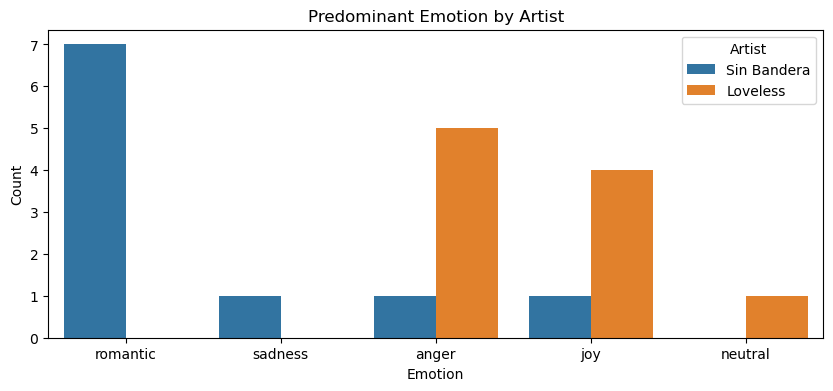

In [26]:
# Predominant emotions for this dataset
plt.figure(figsize=(10, 4))
plt.title('Predominant Emotion by Artist')
sns.countplot(x='lex_based_emotion', hue='artist', data=songs)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend(title='Artist')
plt.show()

## Bigrams

Bigrams allows to see simultaneous occurrence of words. This technique was applied on the lyrics stored in the `lyrics` column, because it stores the version whith less elimination of words. An important ocurrence in Sin Bandera is 'otra vida' and in Loveless is 'the night', taking account for only the meaningful pairs.

In [20]:
# Get top bigrams

# Separate Spanish and English lyrics
sp = songs.loc[songs['language'] == 'Spanish', 'lyrics']
en = songs.loc[songs['language'] == 'English', 'lyrics']

def get_bigrams(subset):
    result = []
    for lyric in subset:
        words = lyric.split()
        result.extend([*zip(words[:-1], words[1:])]) # Extend method concatenates the new list
    return result

sp_bigrams = get_bigrams(sp)
en_bigrams = get_bigrams(en)

# Counter
sp_count = [*Counter(sp_bigrams).most_common(7)]
en_count = [*Counter(en_bigrams).most_common(7)]
print(sp_count, '\n')
print(en_count)

[(('que', 'me'), 30), (('y', 'me'), 22), (('tal', 'vez'), 21), (('lo', 'que'), 18), (('vez', 'en'), 16), (('en', 'otra'), 16), (('otra', 'vida'), 16)] 

[(('in', 'the'), 29), (('me', 'down'), 20), (('of', 'the'), 20), (('the', 'night'), 19), (('i', 'm'), 18), (('the', 'middle'), 18), (('middle', 'of'), 18)]


## Rhyme simplicity score

The rhyme simplicity score takes account for the last words of a verse in each song. For each of those words, a comparison of the two last letters is done against the last two of following word, assigning a score of 1 each time the condition is met.

Songs as 'Sirena' and 'Ves' by Sin Bandera and 'Middle of the night' by Loveless have high scores. 

In [21]:
import re

# Rhyme simplicity score: higher values mean more repetitive/chorus-like structures

# Get the last words of the lines
def get_last_word(lyrics):
    last_words = re.findall(r'(\w+)\s*\n', lyrics) # Returns a list, so split not needed
    return last_words

# Define a function to get the rhyme scores
def rhyme_simple(lyrics):
    words = get_last_word(lyrics)
    # Check last two letters, adding 1 if the condition is met
    return sum(1 for i in range(len(words) - 1) if words[i][-2:] == words[i+1][-2:])

scores = songs['lyrics'].apply(rhyme_simple)

# Add scores to the dataframe
songs['rhyme'] = scores

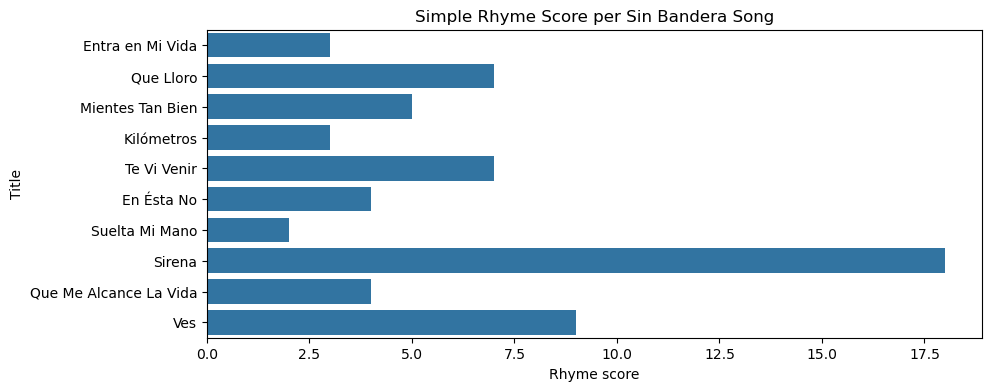

In [22]:
# Plot the rhyme scores: Spanish songs
plt.figure(figsize=(10, 4))
plt.title('Simple Rhyme Score per Sin Bandera Song')
sns.barplot(x='rhyme', y='title', data=songs.loc[songs['language'] == 'Spanish'])
plt.xlabel('Rhyme score')
plt.ylabel('Title')
plt.show()

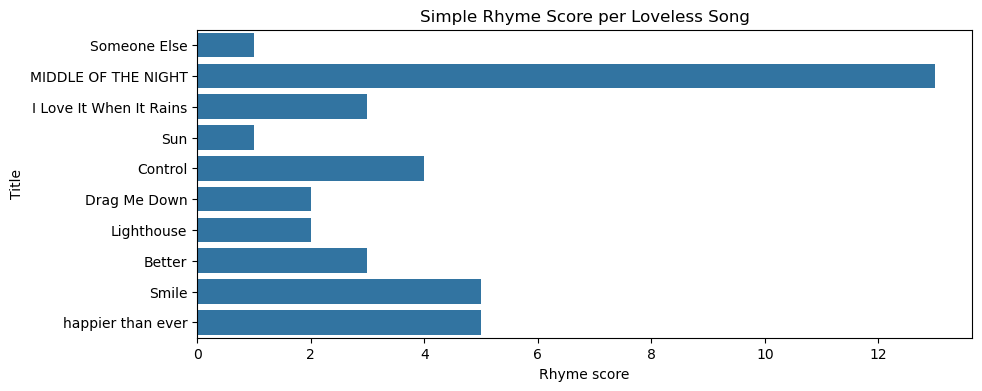

In [23]:
# Plot the rhyme scores: English songs
plt.figure(figsize=(10, 4))
plt.title('Simple Rhyme Score per Loveless Song')
sns.barplot(x='rhyme', y='title', data=songs.loc[songs['language'] == 'English'])
plt.xlabel('Rhyme score')
plt.ylabel('Title')
plt.show()